In [4]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1. Data Preparation

In [5]:
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, flip_y=0.01, class_sep=1.5, random_state=42)

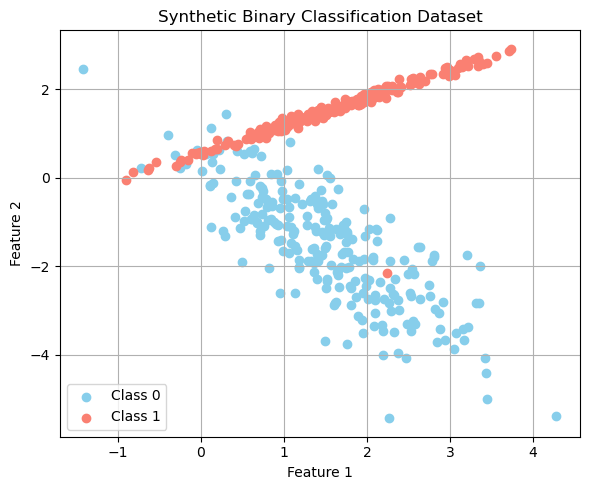

In [6]:
plt.figure(figsize=(6, 5))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='skyblue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='salmon', label='Class 1')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Synthetic Binary Classification Dataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### perceptron needs y is -1 or 1

In [7]:
y_perceptron = y.copy()
y_perceptron[y_perceptron == 0] = -1

In [8]:
X_train, X_test, y_train_p, y_test_p = train_test_split(X, y_perceptron, test_size=0.2, random_state=42)
_, _, y_train_mlp, y_test_mlp = train_test_split(X, y, test_size=0.2, random_state=42)

### Standarization

In [9]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# 2. Perceptron with sklearn

In [10]:
sk_perceptron = SklearnPerceptron()
sk_perceptron.fit(X_train_std, y_train_p)
y_pred_sk_p = sk_perceptron.predict(X_test_std)
acc_sk_p = accuracy_score(y_test_p, y_pred_sk_p)
print(f"Sklearn Perceptron Accuracy: {acc_sk_p}")

Sklearn Perceptron Accuracy: 0.92


# 3. Perceptron with numpy

In [23]:
class PerceptronNumpy:
    def __init__(self, lr=0.1, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        """
        for _ in range(self.n_iter):
            for xi, yi in zip(X, y):
                if yi * (np.dot(xi, self.w) + self.b) <= 0:
                    self.w += self.lr * yi * xi #only add wrong labeled, so will use mask in vectorization 
                    self.b += self.lr * yi
        """

        for _ in range(self.n_iter):
            # 预测 margin（带符号）
            margins = y * (X @ self.w + self.b)  # shape = (n_samples,)
            mask = margins <= 0  # 找到所有分类错误的样本
            if not np.any(mask):
                break  # 若已无误分类样本，提前终止

            X_mis = X[mask]
            y_mis = y[mask]

            # 向量化更新
            self.w += self.lr * np.sum(y_mis[:, np.newaxis] * X_mis, axis=0) # y_mis[:, newaxis] shape (n_mis, 1), after * X_mis, get (n_mis, n_features), sum over axis=0 get (n_features,)
            self.b += self.lr * np.sum(y_mis)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [24]:
manual_perceptron = PerceptronNumpy()
manual_perceptron.fit(X_train_std, y_train_p)
y_pred_manual_p = manual_perceptron.predict(X_test_std)
acc_manual_p = accuracy_score(y_test_p, y_pred_manual_p)
print("Manual Perceptron Accuracy:", acc_manual_p)

Manual Perceptron Accuracy: 0.92


# 4. MLP sklearn

In [25]:
sk_mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000)
sk_mlp.fit(X_train_std, y_train_mlp)
y_pred_sk_mlp = sk_mlp.predict(X_test_std)
acc_sk_mlp = accuracy_score(y_test_mlp, y_pred_sk_mlp)
print("Sklearn MLP Accuracy:", acc_sk_mlp)

Sklearn MLP Accuracy: 0.94


# 5. MLP numpy

In [34]:
class MLPNumpy:
    def __init__(self, input_size, hidden_size, output_size=1, lr=0.1, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_deriv(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        for _ in range(self.epochs):
            #forward
            z1 = X @ self.W1 + self.b1
            a1 = self.sigmoid(z1)
            z2 = a1 @ self.W2 + self.b2
            a2 = self.sigmoid(z2)

            #backprop
            dz2 = a2 - y #binary cross entropy + sigmoid: dloss_dz2 = dloss_da2 * da2_dz2, can do step by step
            dW2 = a1.T @ dz2
            db2 = np.sum(dz2, axis=0, keepdims=True)

            dz1 = dz2 @ self.W2.T * self.sigmoid_deriv(z1)
            dW1 = X.T @ dz1
            db1 = np.sum(dz1, axis=0, keepdims=True)

            #update
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1

    def predict(self, X):
        a1 = self.sigmoid(X @ self.W1 + self.b1)
        a2 = self.sigmoid(a1 @ self.W2 + self.b2)
        return (a2 >= 0.5).astype(int).flatten()

In [35]:
manual_mlp = MLPNumpy(input_size=2, hidden_size=10, lr=0.1, epochs=1000)
manual_mlp.fit(X_train_std, y_train_mlp)
y_pred_manual_mlp = manual_mlp.predict(X_test_std)
acc_manual_mlp = accuracy_score(y_test_mlp, y_pred_manual_mlp)
print("Manual MLP Accuracy:", acc_manual_mlp)

Manual MLP Accuracy: 0.99
